In [1]:
# Section 0: Setup
!pip -q install huggingface_hub opencv-python-headless scikit-learn matplotlib tqdm tensorflow

import os, json, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_auc_score, roc_curve
)

SEED = 576
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [2]:
# Section 1: Download & extract UTA-RLDD_images (Hugging Face) with notebook_login (robust)
!pip -q uninstall -y huggingface-hub
!pip -q install --no-cache-dir --force-reinstall "huggingface-hub==0.34.0"

import sys
from pathlib import Path
import zipfile

# Clear possibly half-imported modules from memory
for m in list(sys.modules.keys()):
    if m.startswith("huggingface_hub"):
        del sys.modules[m]

from huggingface_hub import hf_hub_download, notebook_login

# --- (B) Paths (keep consistent with other sections) ---
OUT_DIR = Path("/content/outputs")
DATA_DIR = Path("/content/data_uta_rldd_images")
FIG_DIR = OUT_DIR / "figures"
MODEL_DIR = OUT_DIR / "models"

for d in [OUT_DIR, FIG_DIR, MODEL_DIR, DATA_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# --- (C) Dataset repo info ---
REPO_ID = "chbh7051/UTA-RLDD_images"
ZIP_FILES = {
    "train": "data/train.zip",
    "validation": "data/validation.zip",
    "test": "data/test.zip",
}

# --- (D) Login (Method 1: interactive prompt) ---
# Paste your HF access token (Read permission is sufficient) when prompted.
notebook_login()

def download_and_extract(split_name: str, repo_filename: str):
    # IMPORTANT: repo_type="dataset" is required for dataset repositories
    zip_path = hf_hub_download(
        repo_id=REPO_ID,
        repo_type="dataset",
        filename=repo_filename,
        token=True,
    )

    split_dir = DATA_DIR / split_name
    split_dir.mkdir(parents=True, exist_ok=True)

    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(split_dir)

    return split_dir

split_dirs = {}
for split, fname in ZIP_FILES.items():
    print(f"Downloading/extracting {split} ...")
    split_dirs[split] = download_and_extract(split, fname)

print("Extracted to:", DATA_DIR)
!find /content/data_uta_rldd_images -maxdepth 3 -type d | head -n 30





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 202.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.7/558.7 kB 216.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 228.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 192.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 258.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 181.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 175.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 199.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 201.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 224.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 172.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Downloading/extracting train ...


data/train.zip:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading/extracting validation ...


data/validation.zip:   0%|          | 0.00/186M [00:00<?, ?B/s]

Downloading/extracting test ...


data/test.zip:   0%|          | 0.00/189M [00:00<?, ?B/s]

Extracted to: /content/data_uta_rldd_images
/content/data_uta_rldd_images
/content/data_uta_rldd_images/train
/content/data_uta_rldd_images/train/train
/content/data_uta_rldd_images/train/train/alert
/content/data_uta_rldd_images/train/train/drowsy
/content/data_uta_rldd_images/validation
/content/data_uta_rldd_images/validation/validation
/content/data_uta_rldd_images/validation/validation/alert
/content/data_uta_rldd_images/validation/validation/drowsy
/content/data_uta_rldd_images/test
/content/data_uta_rldd_images/test/test
/content/data_uta_rldd_images/test/test/alert
/content/data_uta_rldd_images/test/test/drowsy


In [3]:
# Section 2: Create tf.data datasets
IMG_SIZE = 224
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

# Your extracted folders contain ONLY these two classes
CLASS_NAMES = ["alert", "drowsy"]  # 0,1

def make_ds(split: str, shuffle: bool):
    # After extraction, images are under: DATA_DIR/split/split/<class_name>/*.jpg
    # Handle both cases (with or without the extra nested folder).
    split_root = DATA_DIR / split
    candidate = split_root / split
    root_dir = candidate if candidate.exists() else split_root

    ds = tf.keras.utils.image_dataset_from_directory(
        root_dir,
        labels="inferred",
        label_mode="int",
        class_names=CLASS_NAMES,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH,
        shuffle=shuffle,
        seed=SEED
    )
    return ds

# Keep the same variable names to avoid changing later sections
train_mc = make_ds("train", shuffle=True)
val_mc   = make_ds("validation", shuffle=False)
test_mc  = make_ds("test", shuffle=False)

print("Class names:", train_mc.class_names)

# Convert multiclass label -> binary label
# With two classes this is effectively identity, but we keep it to preserve downstream code structure.
def to_binary(images, labels_int):
    # alert -> 0, drowsy -> 1
    binary = tf.cast(labels_int, tf.int32)
    return images, binary

train_bin = train_mc.map(to_binary, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_bin   = val_mc.map(to_binary, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_bin  = test_mc.map(to_binary, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)



Found 5539 files belonging to 2 classes.
Found 692 files belonging to 2 classes.
Found 693 files belonging to 2 classes.
Class names: ['alert', 'drowsy']


In [4]:
# Section 3: Save a sample montage figure (Figure 1)
def save_class_montage(ds_mc, out_path, n_per_class=6, max_take=800):
    """
    Save an image montage with n_per_class samples per class.
    Works for any number of classes defined by CLASS_NAMES.
    If a class has fewer than n_per_class samples collected within max_take,
    blank placeholders will be used instead of crashing.
    """
    n_classes = len(CLASS_NAMES)
    buckets = {k: [] for k in range(n_classes)}

    # Collect samples
    for img, lab in ds_mc.unbatch().take(max_take):
        y = int(lab.numpy())
        if len(buckets[y]) < n_per_class:
            buckets[y].append(tf.cast(img, tf.uint8).numpy())
        if all(len(buckets[k]) >= n_per_class for k in buckets):
            break

    # Prepare figure grid
    fig = plt.figure(figsize=(2.2 * n_per_class, 2.6 * n_classes))
    idx = 1

    for cls in range(n_classes):
        for j in range(n_per_class):
            ax = plt.subplot(n_classes, n_per_class, idx)

            if j < len(buckets[cls]):
                ax.imshow(buckets[cls][j])
            else:
                # blank placeholder
                ax.imshow(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8))

            ax.axis("off")
            if j == 0:
                ax.set_title(CLASS_NAMES[cls])
            idx += 1

    plt.tight_layout()
    fig.savefig(out_path, dpi=200)
    plt.close(fig)

fig1 = FIG_DIR / "fig1_dataset_montage.png"
save_class_montage(train_mc, fig1, n_per_class=6)
print("Saved:", fig1)


Saved: /content/outputs/figures/fig1_dataset_montage.png


In [5]:
# Section 4: Preprocessing & augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomBrightness(0.08),
    layers.RandomContrast(0.10),
], name="augmentation")

def preprocess(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels

train_bin_pp = train_bin.map(preprocess, num_parallel_calls=AUTOTUNE)
val_bin_pp   = val_bin.map(preprocess, num_parallel_calls=AUTOTUNE)
test_bin_pp  = test_bin.map(preprocess, num_parallel_calls=AUTOTUNE)

def augment(images, labels):
    images = data_augmentation(images, training=True)
    images = tf.clip_by_value(images, 0.0, 1.0)
    return images, labels

train_bin_aug = train_bin_pp.map(augment, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_bin_pp    = val_bin_pp.prefetch(AUTOTUNE)
test_bin_pp   = test_bin_pp.prefetch(AUTOTUNE)


In [6]:
# Section 5: EfficientNetB0 transfer learning model (Binary classification)
LR = 1e-4
EPOCHS = 10

def build_efficientnet_binary(img_size=224):
    base = keras.applications.EfficientNetB0(
        include_top=False, weights="imagenet",
        input_shape=(img_size, img_size, 3)
    )
    base.trainable = False

    inp = keras.Input((img_size, img_size, 3))
    x = keras.applications.efficientnet.preprocess_input(inp * 255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out, name="efficientnet_b0_binary")
    return model

model_eff = build_efficientnet_binary(IMG_SIZE)
model_eff.compile(
    optimizer=keras.optimizers.Adam(LR),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")]
)
model_eff.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "efficientnet_b0_binary"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
# Section 6: Small CNN baseline (Binary classification)
def build_smallcnn_binary(img_size=224):
    inp = keras.Input((img_size, img_size, 3))
    x = inp
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out, name="smallcnn_binary")
    return model

model_cnn = build_smallcnn_binary(IMG_SIZE)
model_cnn.compile(
    optimizer=keras.optimizers.Adam(LR),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")]
)
model_cnn.summary()


Model: "smallcnn_binary"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Section 7: Train models + save training curves (Figure 2)
callbacks_eff = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(str(MODEL_DIR / "best_efficientnet.keras"),
                                    monitor="val_auc", mode="max", save_best_only=True)
]

callbacks_cnn = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(str(MODEL_DIR / "best_smallcnn.keras"),
                                    monitor="val_auc", mode="max", save_best_only=True)
]

hist_eff = model_eff.fit(train_bin_aug, validation_data=val_bin_pp, epochs=EPOCHS, callbacks=callbacks_eff)
hist_cnn = model_cnn.fit(train_bin_aug, validation_data=val_bin_pp, epochs=EPOCHS, callbacks=callbacks_cnn)

def plot_history(hist, out_path, title):
    fig = plt.figure(figsize=(8,4))
    plt.plot(hist.history.get("acc", []), label="train_acc")
    plt.plot(hist.history.get("val_acc", []), label="val_acc")
    plt.plot(hist.history.get("auc", []), label="train_auc")
    plt.plot(hist.history.get("val_auc", []), label="val_auc")
    plt.xlabel("Epoch"); plt.ylabel("Metric"); plt.title(title)
    plt.legend(); plt.tight_layout()
    fig.savefig(out_path, dpi=200)
    plt.close(fig)

fig2a = FIG_DIR / "fig2a_train_curve_efficientnet.png"
fig2b = FIG_DIR / "fig2b_train_curve_smallcnn.png"
plot_history(hist_eff, fig2a, "Training Curves - EfficientNetB0 (Binary)")
plot_history(hist_cnn, fig2b, "Training Curves - Small CNN (Binary)")

print("Saved:", fig2a)
print("Saved:", fig2b)


Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 123s 508ms/step - acc: 0.5124 - auc: 0.5086 - loss: 0.6972 - val_acc: 0.6243 - val_auc: 0.6736 - val_loss: 0.6567
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 55s 312ms/step - acc: 0.5142 - auc: 0.5080 - loss: 0.6992 - val_acc: 0.6821 - val_auc: 0.7490 - val_loss: 0.6302
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 81s 310ms/step - acc: 0.5052 - auc: 0.4974 - loss: 0.6971 - val_acc: 0.7095 - val_auc: 0.7926 - val_loss: 0.6039
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 83s 318ms/step - acc: 0.5065 - auc: 0.5080 - loss: 0.6946 - val_acc: 0.7500 - val_auc: 0.8434 - val_loss: 0.5733
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 54s 308ms/step - acc: 0.5093 - auc: 0.5155 - loss: 0.6918 - val_acc: 0.7645 - val_auc: 0.8742 - val_loss: 0.5542
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 81s 304ms/step - acc: 0.4962 - auc: 0.4890 - loss: 0.6944 - val_acc: 0.7977 - val_auc: 0.9085 - val_loss: 0.5292
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 83s 312ms/step - acc: 0.5178 - auc: 0.515

In [9]:
# Section 8: Evaluate models + save confusion matrix & ROC curves (Figures 3-4)
def eval_binary(model, ds):
    y_true, y_prob = [], []
    for x, y in ds:
        p = model.predict(x, verbose=0).reshape(-1)
        y_true.extend(y.numpy().reshape(-1).tolist())
        y_prob.extend(p.tolist())
    y_true = np.array(y_true).astype(int)
    y_prob = np.array(y_prob).astype(float)
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = float("nan")

    cm = confusion_matrix(y_true, y_pred)
    return {"acc": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1), "auc": float(auc)}, cm, y_true, y_prob

def save_confusion_matrix(cm, out_path, title):
    fig = plt.figure(figsize=(4.6,4.0))
    plt.imshow(cm)
    plt.title(title)
    plt.xticks([0,1], ["alert(0)", "non-alert(1)"])
    plt.yticks([0,1], ["alert(0)", "non-alert(1)"])
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    fig.savefig(out_path, dpi=200)
    plt.close(fig)

def save_roc_curve(y_true, y_prob, out_path, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    fig = plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.tight_layout()
    fig.savefig(out_path, dpi=200)
    plt.close(fig)

metrics_eff, cm_eff, yt_eff, yp_eff = eval_binary(model_eff, test_bin_pp)
metrics_cnn, cm_cnn, yt_cnn, yp_cnn = eval_binary(model_cnn, test_bin_pp)

fig3a = FIG_DIR / "fig3a_cm_efficientnet.png"
fig3b = FIG_DIR / "fig3b_cm_smallcnn.png"
save_confusion_matrix(cm_eff, fig3a, "Confusion Matrix - EfficientNetB0 (Binary)")
save_confusion_matrix(cm_cnn, fig3b, "Confusion Matrix - Small CNN (Binary)")

fig4a = FIG_DIR / "fig4a_roc_efficientnet.png"
fig4b = FIG_DIR / "fig4b_roc_smallcnn.png"
save_roc_curve(yt_eff, yp_eff, fig4a, "ROC - EfficientNetB0 (Binary)")
save_roc_curve(yt_cnn, yp_cnn, fig4b, "ROC - Small CNN (Binary)")

metrics = {"efficientnet_b0": metrics_eff, "smallcnn": metrics_cnn}
with open(OUT_DIR / "test_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Test metrics:", metrics)
print("Saved metrics to:", OUT_DIR / "test_metrics.json")
print("Figures saved to:", FIG_DIR)


Test metrics: {'efficientnet_b0': {'acc': 0.8585858585858586, 'precision': 0.8559556786703602, 'recall': 0.8704225352112676, 'f1': 0.8631284916201117, 'auc': 0.9522543545295441}, 'smallcnn': {'acc': 0.5122655122655123, 'precision': 0.5122655122655123, 'recall': 1.0, 'f1': 0.6774809160305344, 'auc': 0.4883573631135928}}
Saved metrics to: /content/outputs/test_metrics.json
Figures saved to: /content/outputs/figures


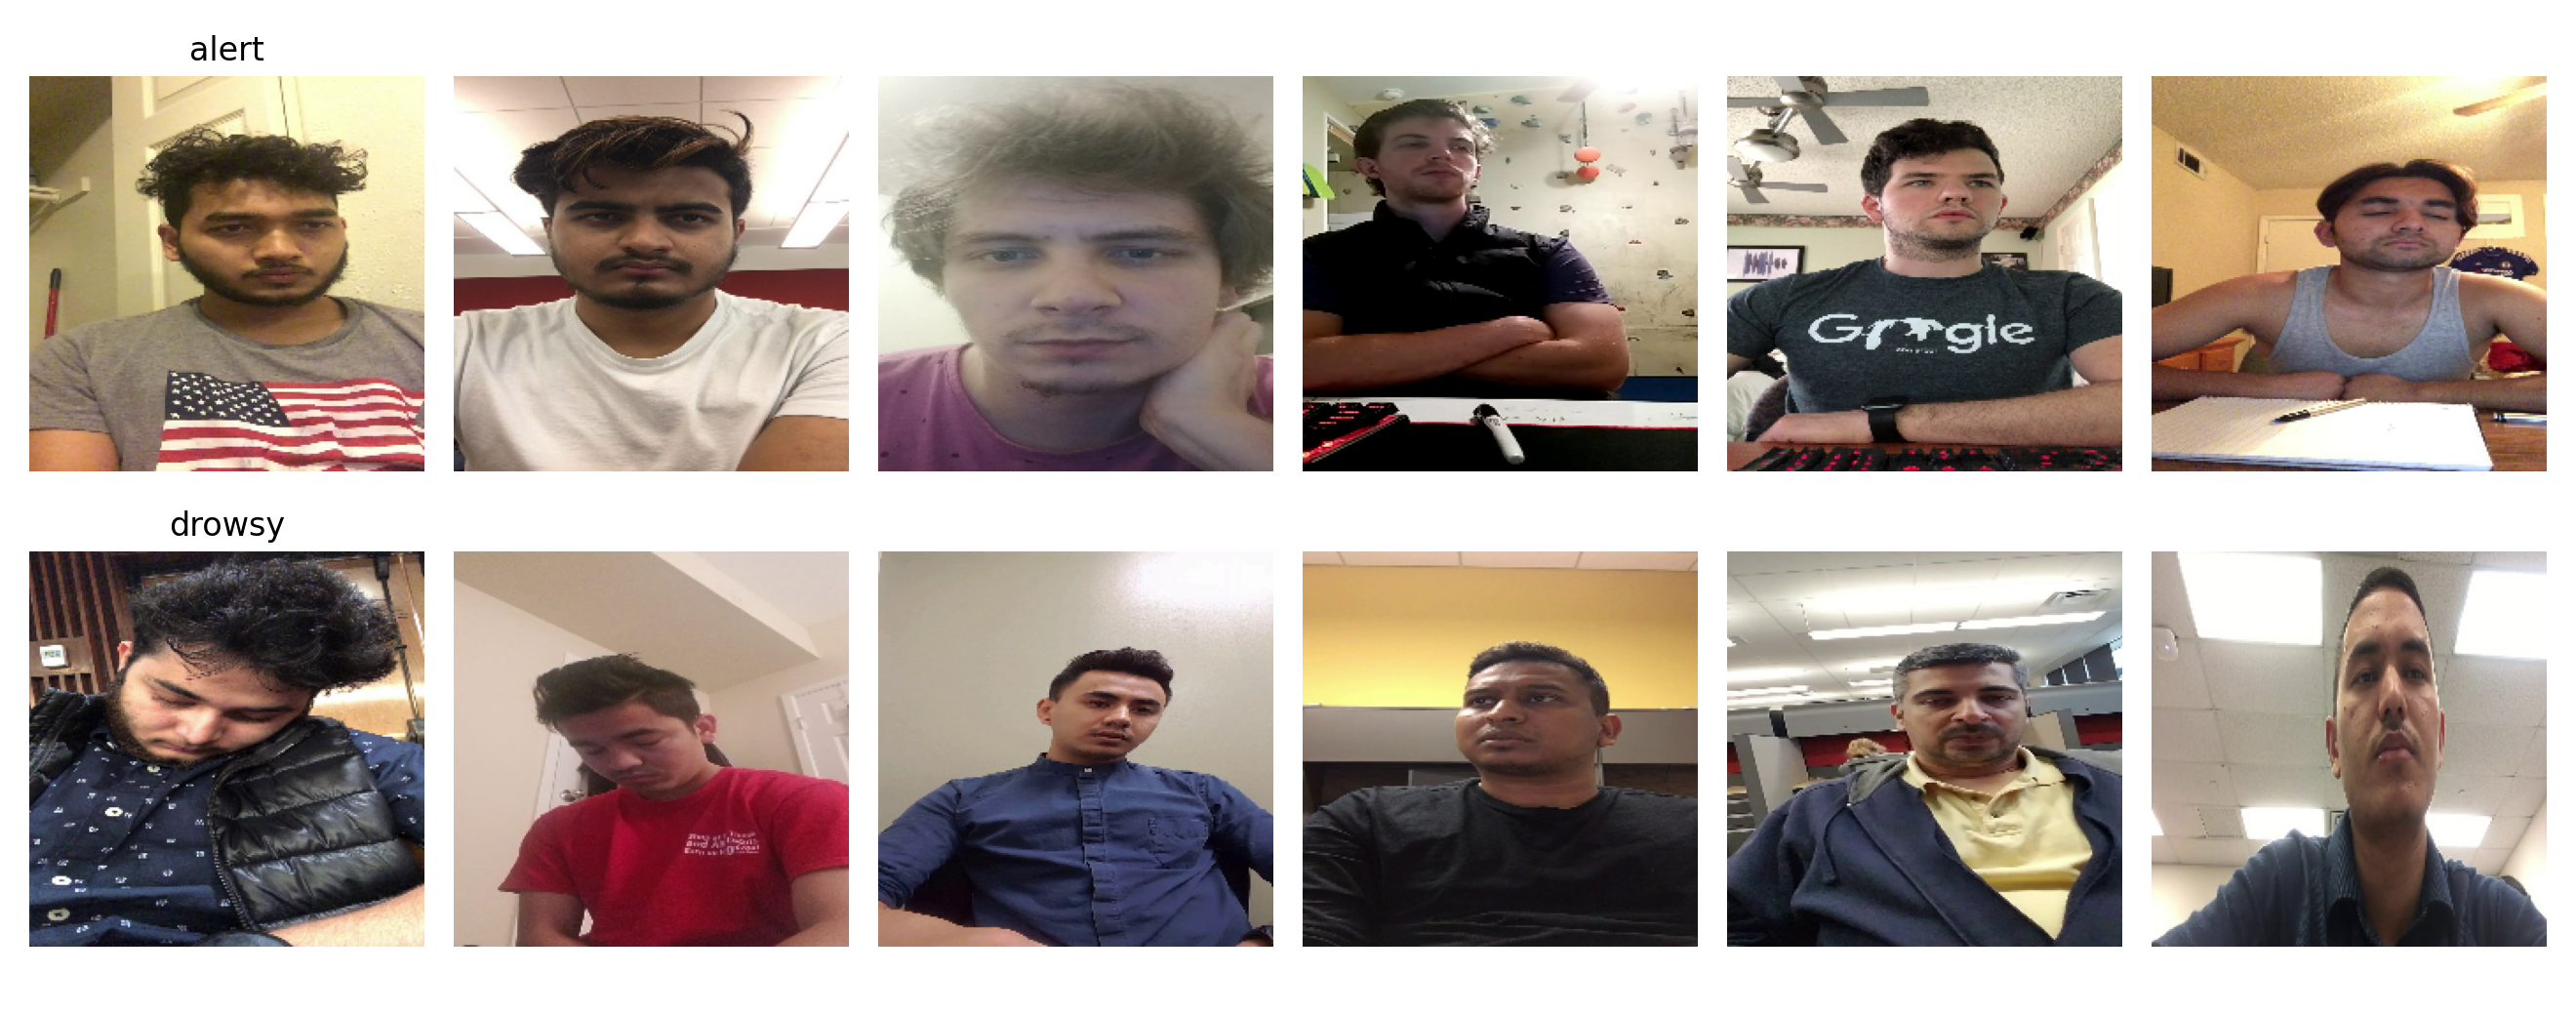

**Fig. 1. Example samples from the dataset (binary classes: alert vs. drowsy).**

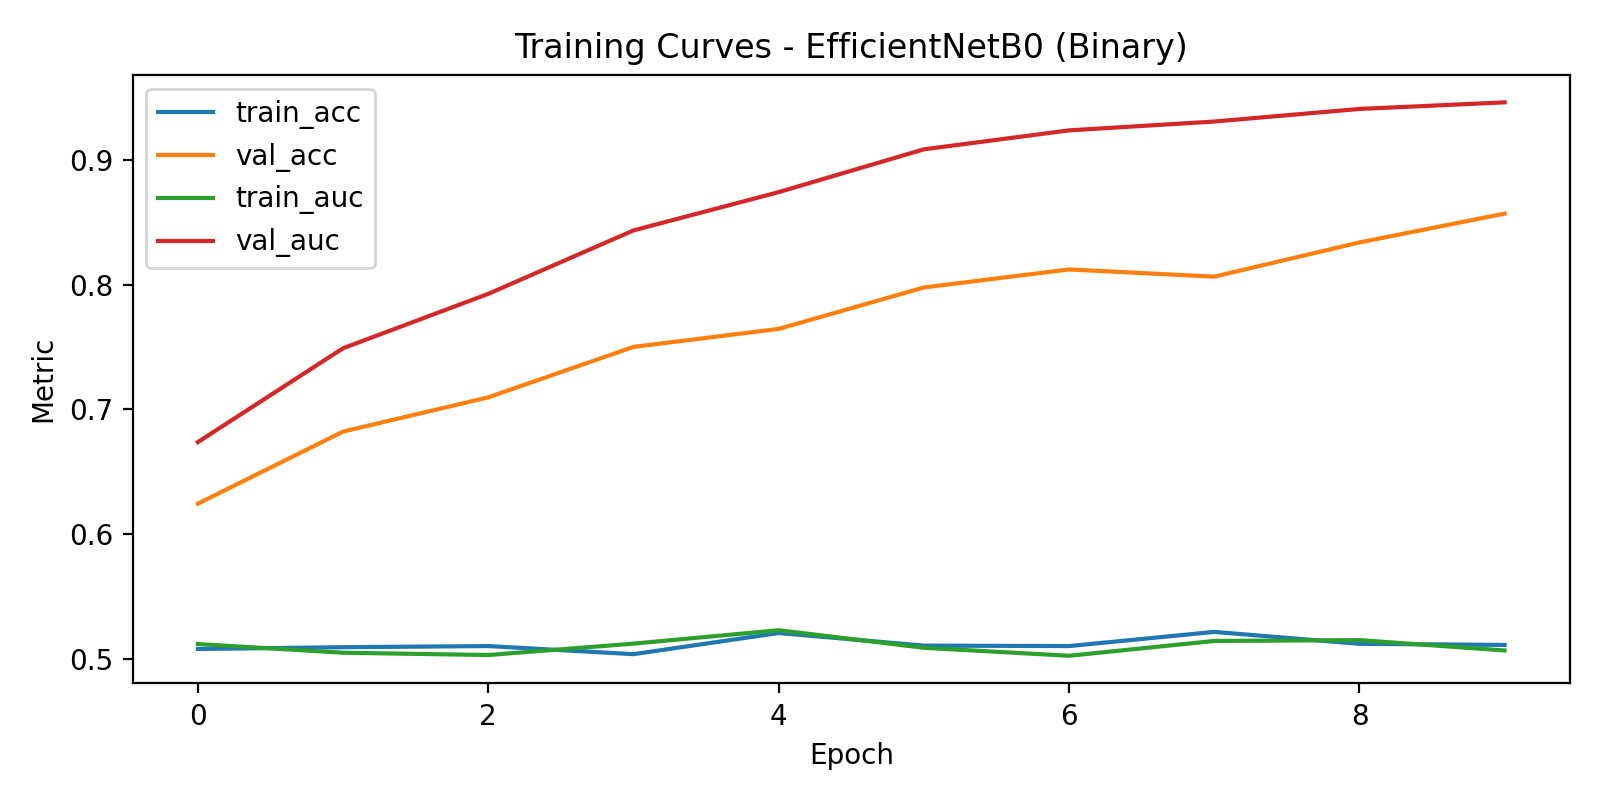

**Fig. 2. Training curves for EfficientNetB0 transfer learning (accuracy and ROC-AUC vs. epoch).**

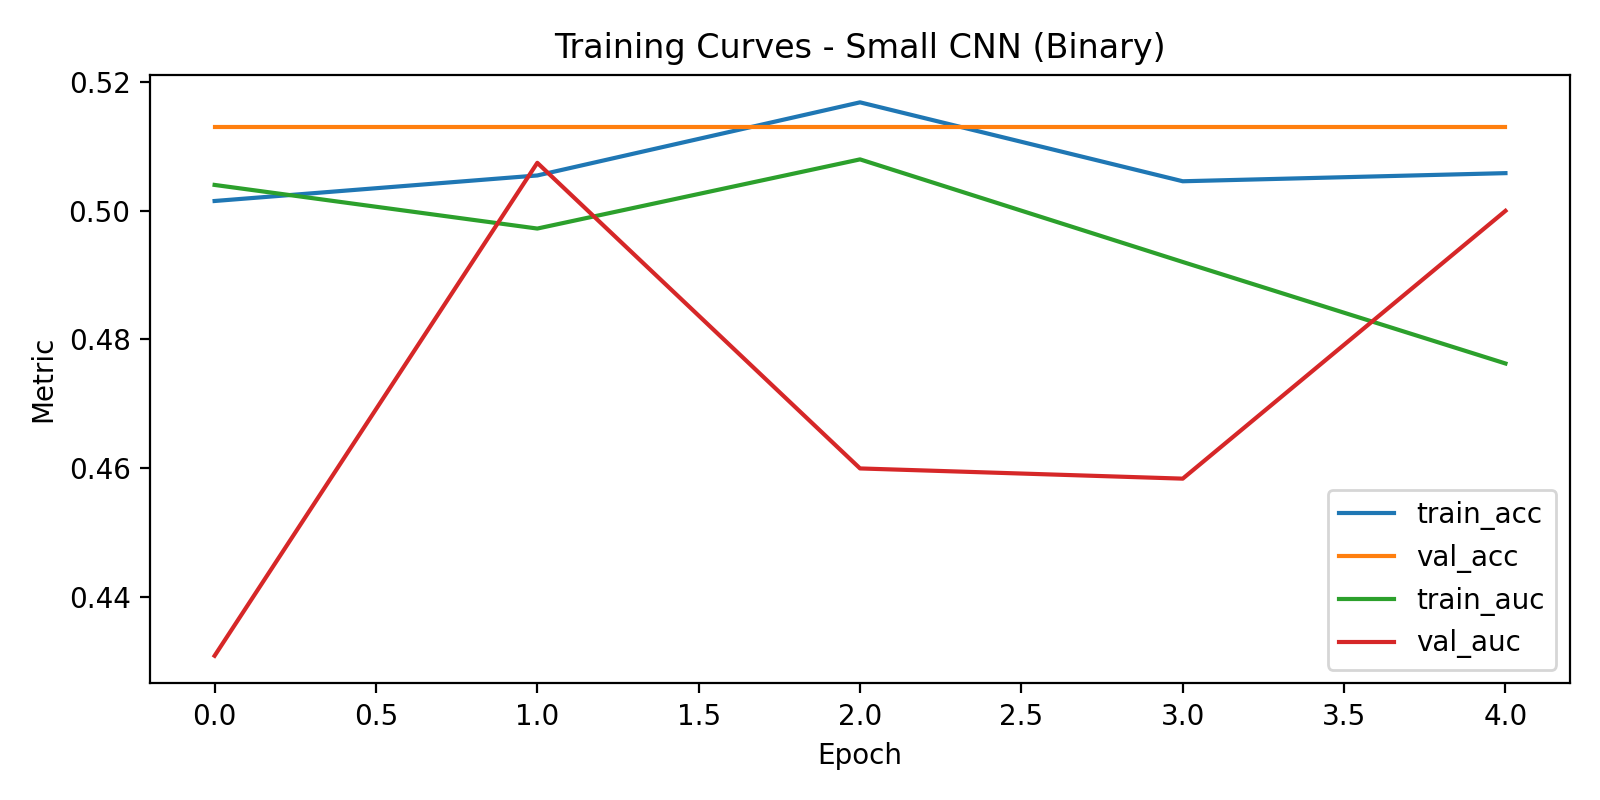

**Fig. 3. Training curves for the small CNN baseline trained from scratch (accuracy and ROC-AUC vs. epoch).**

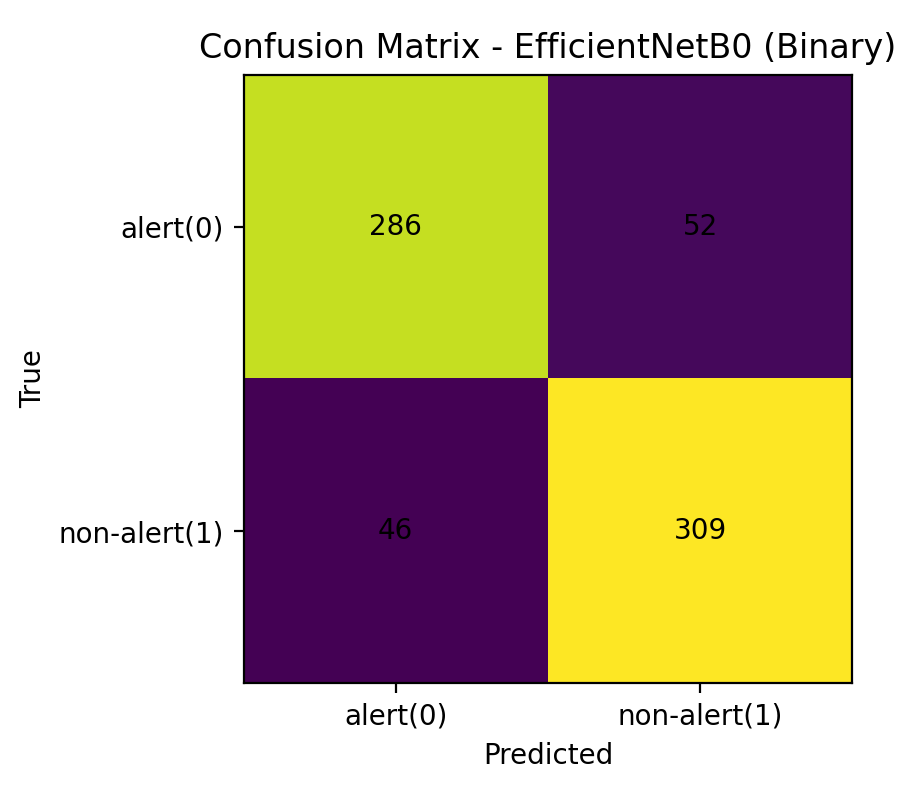

**Fig. 4. Confusion matrix on the test split for EfficientNetB0.**

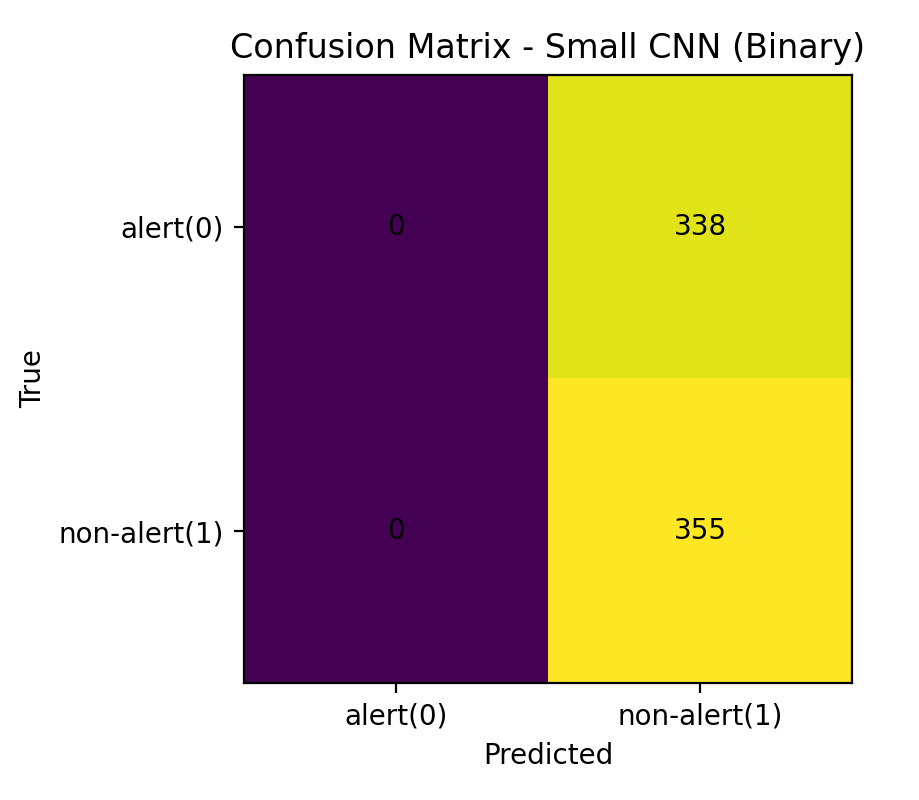

**Fig. 5. Confusion matrix on the test split for the small CNN baseline.**

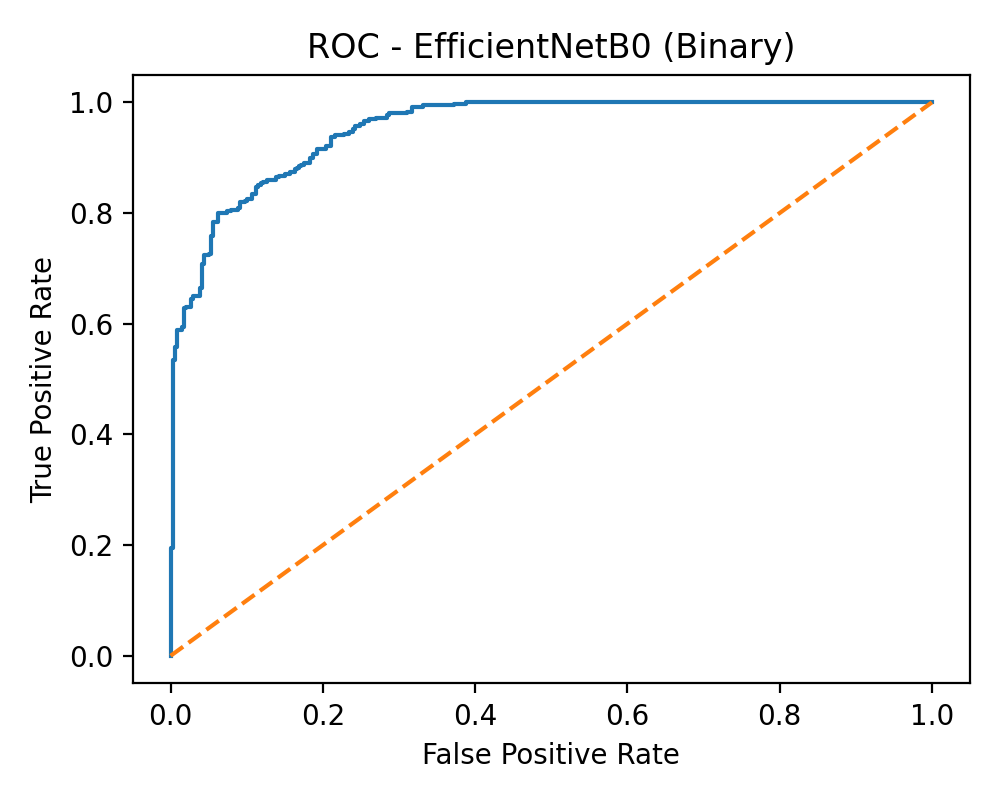

**Fig. 6. ROC curve on the test split for EfficientNetB0.**

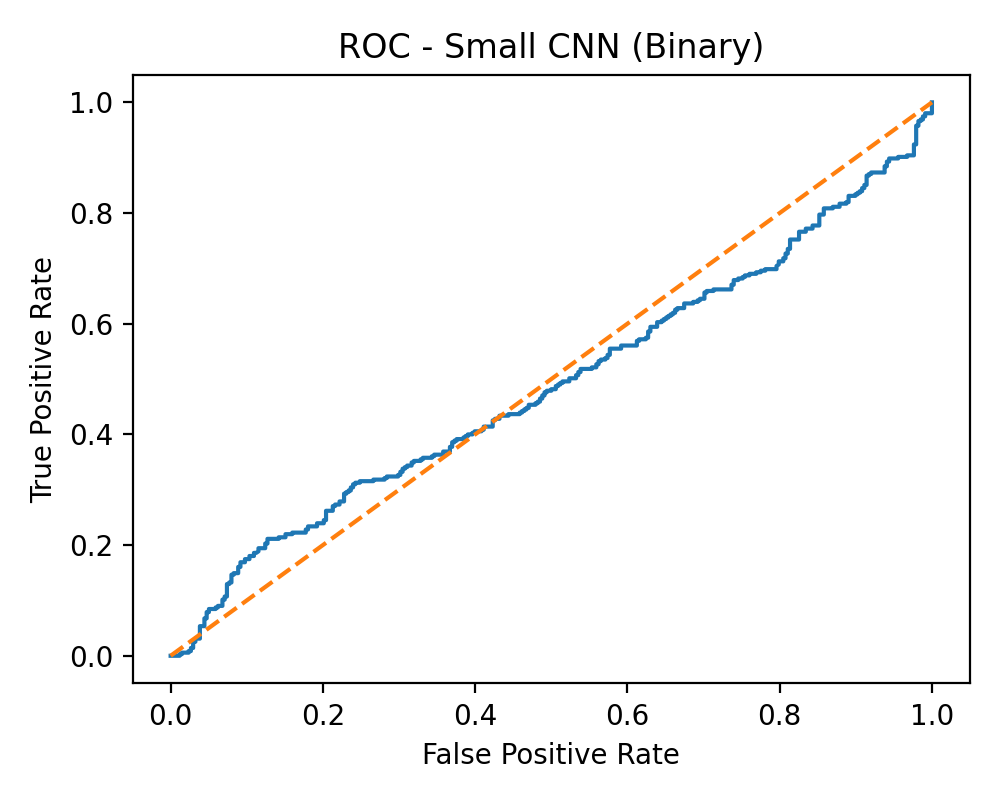

**Fig. 7. ROC curve on the test split for the small CNN baseline.**

**Table I. Test performance (binary classification)**

,acc,precision,recall,f1,auc
efficientnet_b0,0.858586,0.855956,0.870423,0.863128,0.952254
smallcnn,0.512266,0.512266,1.000000,0.677481,0.488357


In [10]:
# Section 9: Display generated figures with IEEE-style captions (no re-saving)

from IPython.display import Image, display, Markdown
from pathlib import Path

def show_fig(path: Path, caption: str, width: int = 900):
    if path.exists():
        display(Image(filename=str(path), width=width))
        display(Markdown(f"**{caption}**"))
    else:
        display(Markdown(f"*Missing figure:* `{path.name}`"))

# Update captions/text as you like for your final IEEE report
figure_list = [
    ("fig1_dataset_montage.png",
     "Fig. 1. Example samples from the dataset (binary classes: alert vs. drowsy)."),

    ("fig2a_train_curve_efficientnet.png",
     "Fig. 2. Training curves for EfficientNetB0 transfer learning (accuracy and ROC-AUC vs. epoch)."),

    ("fig2b_train_curve_smallcnn.png",
     "Fig. 3. Training curves for the small CNN baseline trained from scratch (accuracy and ROC-AUC vs. epoch)."),

    ("fig3a_cm_efficientnet.png",
     "Fig. 4. Confusion matrix on the test split for EfficientNetB0."),

    ("fig3b_cm_smallcnn.png",
     "Fig. 5. Confusion matrix on the test split for the small CNN baseline."),

    ("fig4a_roc_efficientnet.png",
     "Fig. 6. ROC curve on the test split for EfficientNetB0."),

    ("fig4b_roc_smallcnn.png",
     "Fig. 7. ROC curve on the test split for the small CNN baseline."),
]

for fname, caption in figure_list:
    show_fig(FIG_DIR / fname, caption)

# Optional: show metrics table (printed, not saved)
try:
    import pandas as pd
    display(Markdown("**Table I. Test performance (binary classification)**"))
    display(pd.DataFrame(metrics).T)
except Exception as e:
    print("Could not display metrics table:", e)
